## Tensorboard Visualization

In [1]:
#%reset #clear namespace in dictionary
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot = True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [3]:
from tensorflow.python.framework import ops
ops.reset_default_graph() #resets the graph and removes previous runs


with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, [None, 784],name='x_data') #example vectors are horizontal here so we'll transpose it on multiplication
    Ydata = tf.placeholder(tf.float32, [None, 10],name='y_data') #validation label vectors are also horizontal 
with tf.name_scope("fitting_variables"):
    with tf.name_scope("weights"):
        W = tf.Variable(tf.ones([10,784]),name='w')
        tf.summary.histogram("wieghts",W)
    with tf.name_scope("bias"):
        b = tf.Variable(tf.ones([10]),name='b')
        tf.summary.histogram("biases",b)
prod=tf.matmul(W,X,transpose_b=True)
sumation=tf.transpose(tf.transpose(prod) + b) #add b vertically (column by column) to the matrix

with tf.name_scope("outputs"):
    with tf.name_scope("model_output"):
        Ymod = tf.nn.softmax(tf.transpose(sumation),name="y_mod") #example label vectors are horizontal now,softmax normalization is applied this way
    with tf.name_scope("cross_entropy"):
        cross_entropy = tf.reduce_mean(-tf.reduce_sum(Ydata * tf.log(Ymod), reduction_indices=[1])) 
        tf.summary.scalar("cross_entropy",cross_entropy)
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
    correct_prediction = tf.equal(tf.argmax(Ymod,1), tf.argmax(Ydata,1)) #compares horizontally,i.e. component of each vector
    with tf.name_scope("accuracy"):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) #percentage of correct predictions
        tf.summary.scalar("accuracy",accuracy)

batch_size=100
no_of_epochs=20

#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#session = tf.Session(config=config, ...)

with tf.Session() as sess2:
    
    summaries_dir="test_logs/"
    #writer = tf.summary.FileWriter(summaries_dir,sess2.graph)
    train_writer = tf.summary.FileWriter(summaries_dir + '/train',sess2.graph)
    valid_writer = tf.summary.FileWriter(summaries_dir + '/valid')
    test_writer = tf.summary.FileWriter(summaries_dir + '/test')

    merged=tf.summary.merge_all()
    #test_writer = tf.summary.FileWriter(summaries_dir)
    
    tf.global_variables_initializer().run()
    #initial calculation of accuracy, loss,etc.
    summary,loss=sess2.run([merged,cross_entropy],feed_dict={X: mnist.train.images,Ydata: mnist.train.labels})
    train_writer.add_summary(summary, 0)
    #print("Epoch:=",0,"; \t Epoch Loss:=",loss)
    summary,t_acc=sess2.run([merged,accuracy], feed_dict={X: mnist.train.images, Ydata: mnist.train.labels})#calculates accuracy across all data
    train_writer.add_summary(summary, 0)
    #print("Training Accuracy is", t_acc*100,"%")
    summary,v_acc=sess2.run([merged,accuracy], feed_dict={X: mnist.validation.images,Ydata:mnist.validation.labels})
    valid_writer.add_summary(summary,0)
    #print("Validation Accuracy is", v_acc*100,"%")
    summary,f_acc=sess2.run([merged,accuracy], feed_dict={X: mnist.test.images,Ydata:mnist.test.labels})
    test_writer.add_summary(summary,0)
    #print("Test Accuracy is", f_acc*100,"%")
    sum_data=np.array([0,loss,t_acc,v_acc,f_acc])
    
    for epoch in range(no_of_epochs):
        epoch_loss=0
        for i in range(int(mnist.train.num_examples/batch_size)): 
            batch_xs, batch_ys = mnist.train.next_batch(batch_size) #selects a random batch from the dataset for given size
            train,loss=sess2.run([train_step,cross_entropy], feed_dict={X: batch_xs, Ydata: batch_ys})
            #this calculates gradient on the batch and performs one step with in the direction (all variables are used)
            epoch_loss+=loss #calculates loss for each batch and adds it up to calculate entire training data loss
        #print("Epoch:=",epoch+1,"; \t Epoch Loss:=",epoch_loss)
        summary,t_acc=sess2.run([merged,accuracy], feed_dict={X: mnist.train.images, Ydata: mnist.train.labels})#calculates accuracy across all data
        train_writer.add_summary(summary, epoch+1)
        #print("Training Accuracy is", t_acc*100,"%")
        summary,v_acc=sess2.run([merged,accuracy], feed_dict={X: mnist.validation.images,Ydata:mnist.validation.labels})
        valid_writer.add_summary(summary, epoch+1)
        #print("Validation Accuracy is", v_acc*100,"%")
        summary,f_acc=sess2.run([merged,accuracy], feed_dict={X: mnist.test.images,Ydata:mnist.test.labels})
        test_writer.add_summary(summary, epoch+1)
        #print("Test Accuracy is", f_acc*100,"%")
        
        sum_data=np.vstack((sum_data,np.array([epoch+1,epoch_loss,t_acc,v_acc,f_acc])))
        print("Finished Epoch",epoch+1)

Finished Epoch 1
Finished Epoch 2
Finished Epoch 3
Finished Epoch 4
Finished Epoch 5
Finished Epoch 6
Finished Epoch 7
Finished Epoch 8
Finished Epoch 9
Finished Epoch 10
Finished Epoch 11
Finished Epoch 12
Finished Epoch 13
Finished Epoch 14
Finished Epoch 15
Finished Epoch 16
Finished Epoch 17
Finished Epoch 18
Finished Epoch 19
Finished Epoch 20


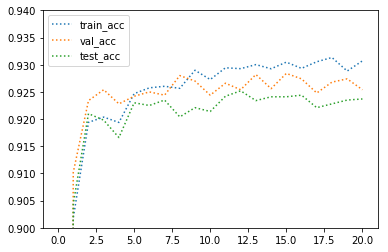

In [4]:
#plt.plot(sum_data[:,0],sum_data[:,1],label="epoch_loss")
plt.ylim(0.9,0.94)
plt.plot(sum_data[:,0],sum_data[:,2],label="train_acc",ls=':')
plt.plot(sum_data[:,0],sum_data[:,3],label="val_acc",ls=':')
plt.plot(sum_data[:,0],sum_data[:,4],label="test_acc",ls=':')
plt.legend()
plt.show()
#test and validationa accuracy get stuck over time(overfitting) 
#the optimal no of epoch seems to be around 10-15 epochs

##  Saving and Restoring Data

In [5]:
#saving
W = tf.Variable([[1,2,3],[1,2,3]],dtype=tf.float32,name='s_weights')
b = tf.Variable([[1,2,3]],dtype=tf.float32,name='s_biases')

init=tf.global_variables_initializer()
saver= tf.train.Saver()
with tf.Session() as sess:
    sess.run(init)
    save_path=saver.save(sess,"test/my_nn_savefile.ckpt")
    print("Save to",save_path)
    
tf.reset_default_graph()

Save to test/my_nn_savefile.ckpt


In [6]:
#restoring
W=tf.Variable(tf.zeros([2,3]),dtype=tf.float32,name='s_weights')
b=tf.Variable(tf.zeros([1,3]),dtype=tf.float32,name='s_biases')

saver=tf.train.Saver()
# Add ops to save and restore only `b` using the name "b"
#saver = tf.train.Saver({"b": b})
#we'll have to initialize W since saver does not do that

with tf.Session() as sess:
    saver.restore(sess,"test/my_nn_savefile.ckpt")
    print("weights:",sess.run(W))
    print("biases:",sess.run(b))

INFO:tensorflow:Restoring parameters from test/my_nn_savefile.ckpt
weights: [[ 1.  2.  3.]
 [ 1.  2.  3.]]
biases: [[ 1.  2.  3.]]


## Convolutional NN (MNIST Example)

In [2]:
? tf.train.GradientDescentOptimizer()

In [25]:
from tensorflow.python.framework import ops
ops.reset_default_graph() #resets the graph and removes previous runs


def compute_accuracy(v_xs, v_ys):
    global Ymod
    y_pre = sess.run(Ymod, feed_dict={xs: v_xs, keep_prob: 1})
    correct_prediction = tf.equal(tf.argmax(y_pre,1), tf.argmax(v_ys,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    result = sess.run(accuracy, feed_dict={xs: v_xs, ys: v_ys, keep_prob: 1})
    return result

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    # stride [1, x_movement, y_movement, 1]
    # Must have strides[0] = strides[3] = 1
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    # stride [1, x_movement, y_movement, 1]
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

# define placeholder for inputs to network
X = tf.placeholder(tf.float32, [None, 784])/255.   # 28x28
Ydata = tf.placeholder(tf.float32, [None, 10])
keep_prob = tf.placeholder(tf.float32)
x_image = tf.reshape(X, [-1, 28, 28, 1])
#print(x_image.shape)  # [n_samples, 28,28,1]
#print(X.shape)

## conv1 layer ##
W_conv1 = weight_variable([5,5, 1,32]) # patch 5x5, in size 1, out size 32
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1) # output size 28x28x32
h_pool1 = max_pool_2x2(h_conv1)                                         # output size 14x14x32

## conv2 layer ##
W_conv2 = weight_variable([5,5, 32, 64]) # patch 5x5, in size 32, out size 64
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2) # output size 14x14x64
h_pool2 = max_pool_2x2(h_conv2)                                         # output size 7x7x64

## fc1 layer ##
W_fc1 = weight_variable([7*7*64, 1024])
b_fc1 = bias_variable([1024])
# [n_samples, 7, 7, 64] ->> [n_samples, 7*7*64]
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

## fc2 layer ##
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])
Ymod = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
print(W_fc2.shape,b_fc2.shape)

# the error between prediction and real data
cross_entropy = tf.reduce_mean(-tf.reduce_sum(Ydata * tf.log(Ymod),reduction_indices=[1]))  
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(Ymod,1), tf.argmax(Ydata,1)) #compares horizontally,i.e. component of each vector
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)) #percentage of correct predictions

batch_size=100
no_of_epochs=20
keep_probability=0.5

with tf.Session() as sess:
    tf.global_variables_initializer().run()

    #for i in range(200):
       # batch_xs, batch_ys = mnist.train.next_batch(100)
       # sess.run(train_step, feed_dict={X: batch_xs, Ydata: batch_ys, keep_prob: keep_probability})
       # if i % 50 == 0:
       #     print(compute_accuracy(mnist.test.images[:1000], mnist.test.labels[:1000]))
    
    #initial calculation of accuracy, loss,etc.
    #loss=sess.run(cross_entropy,feed_dict={X: mnist.train.images,Ydata: mnist.train.labels, keep_prob: keep_probability})
    #t_acc=sess.run(accuracy, feed_dict={X: mnist.train.images, Ydata: mnist.train.labels, keep_prob: keep_probability})
    #v_acc=sess.run(accuracy, feed_dict={X: mnist.validation.images,Ydata:mnist.validation.labels, keep_prob: keep_probability})
    #f_acc=sess.run(accuracy, feed_dict={X: mnist.test.images,Ydata:mnist.test.labels, keep_prob: keep_probability})
    #sum_data=np.array([0,loss,t_acc,v_acc,f_acc])
    
    for epoch in range(no_of_epochs):
        epoch_loss=0.0
        t_acc=0.0
        for i in range(int(mnist.train.num_examples/batch_size)): 
            batch_xs, batch_ys = mnist.train.next_batch(batch_size) #selects a random batch from the dataset for given size
            train,loss=sess.run([train_step,cross_entropy], feed_dict={X: batch_xs, Ydata: batch_ys, keep_prob: keep_probability})
            acc=sess.run(accuracy, feed_dict={X: batch_xs, Ydata: batch_ys, keep_prob: 1.0})
            epoch_loss+=(loss*batch_size)
            t_acc+=(acc*batch_size)
            
        epoch_loss=epoch_loss/mnist.train.num_examples
        t_acc=t_acc/mnist.train.num_examples
        #t_acc=sess.run(accuracy, feed_dict={X: mnist.train.images, Ydata: mnist.train.labels, keep_prob: keep_probability})
        #print("Training Accuracy is", t_acc*100,"%")
        #v_acc=sess.run(accuracy, feed_dict={X: mnist.validation.images,Ydata:mnist.validation.labels, keep_prob: keep_probability})
        #print("Validation Accuracy is", v_acc*100,"%")
        #f_acc=sess.run(accuracy, feed_dict={X: mnist.test.images,Ydata:mnist.test.labels, keep_prob: keep_probability})
        #print("Test Accuracy is", f_acc*100,"%")
        
        #sum_data=np.vstack((sum_data,np.array([epoch+1,epoch_loss,t_acc,v_acc,f_acc])))
        print("Finished Epoch",epoch+1,"Epoch Loss",epoch_loss,"Training Acc",t_acc*100,"%") #,"Acc=",t_acc,v_acc,f_acc)
    print("Finished Training")
    test_acc=0.0
    for i in range(int(mnist.test.num_examples/batch_size)): 
        batch_xs, batch_ys = mnist.test.next_batch(batch_size) #selects a random batch from the dataset for given size
        acc=sess.run(accuracy,feed_dict={X: batch_xs, Ydata: batch_ys, keep_prob: 1.0})
        test_acc+=(acc*batch_size)
    test_acc=test_acc/mnist.test.num_examples
    print("Test Accuracy",test_acc*100,"%")

(1024, 10) (10,)
Finished Epoch 1 Epoch Loss 0.804696804434 Training Acc 88.4727270251 %
Finished Epoch 2 Epoch Loss 0.184520744925 Training Acc 96.5999986584 %
Finished Epoch 3 Epoch Loss 0.124514150298 Training Acc 97.7290886099 %
Finished Epoch 4 Epoch Loss 0.0956081193245 Training Acc 98.259996956 %
Finished Epoch 5 Epoch Loss 0.0773399806361 Training Acc 98.6036334471 %
Finished Epoch 6 Epoch Loss 0.0669673652998 Training Acc 98.8436331857 %
Finished Epoch 7 Epoch Loss 0.0541498259201 Training Acc 99.1018147252 %
Finished Epoch 8 Epoch Loss 0.0477632540583 Training Acc 99.2163601789 %
Finished Epoch 9 Epoch Loss 0.0420922714218 Training Acc 99.3472688632 %
Finished Epoch 10 Epoch Loss 0.0372314641013 Training Acc 99.4545416507 %
Finished Epoch 11 Epoch Loss 0.0309862921398 Training Acc 99.5854508335 %
Finished Epoch 12 Epoch Loss 0.0282241699364 Training Acc 99.6072687669 %
Finished Epoch 13 Epoch Loss 0.0237030145975 Training Acc 99.6890870658 %
Finished Epoch 14 Epoch Loss 0.023